##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections: 

* Forecast for a single timestep:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.

## Setup

Colab now has *tfp* installed by default. 

In [ ]:
# !pip install tensorflow-probability

In [ ]:
import os
import datetime
from time import time as timer

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn import metrics
from sklearn import preprocessing

In [ ]:
mpl.rcParams['figure.figsize'] = (16, 9)
mpl.rcParams['axes.grid'] = False
sns.set()

## The weather dataset
This tutorial uses a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

This tutorial will just deal with **hourly predictions**, so start by sub-sampling the data from 10 minute intervals to 1h:

In [ ]:
df = pd.read_csv(csv_path)
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Let's take a glance at the data. Here are the first few rows:

In [ ]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here is the evolution of a few features over time. 

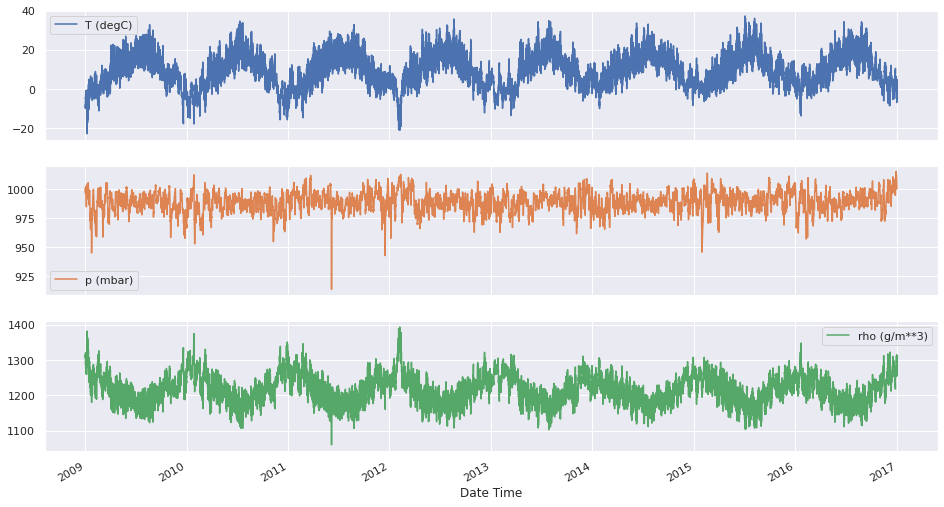

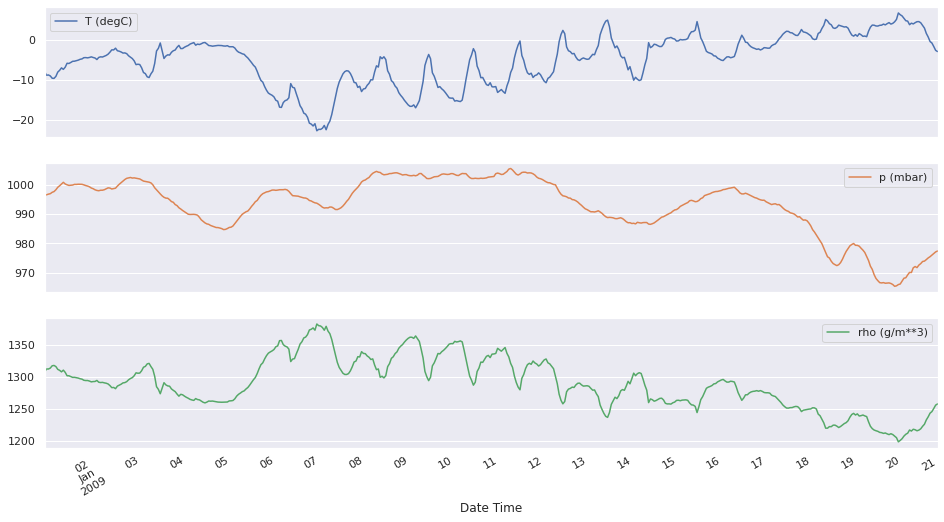

In [ ]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Inspect and cleanup

Next look at the statistics of the dataset:

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### Wind velocity

One thing that should stand out is the `min` value of the wind velocity, `wv (m/s)` and `max. wv (m/s)` columns. This `-9999` is likely erroneous. There's a separate wind direction column, so the velocity should be `>=0`. Replace it with zeros:


In [ ]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

### Feature engineering

Before diving in to build a model it's important to understand your data, and be sure that you're passing the model appropriately formatted data.

#### Wind
The last column of the data, `wd (deg)`, gives the wind direction in units of degrees. Angles do not make good model inputs, 360° and 0° should be close to each other, and wrap around smoothly. Direction shouldn't matter if the wind is not blowing. 

Right now the distribution of wind data looks like this:

Text(0, 0.5, 'Wind Velocity [m/s]')

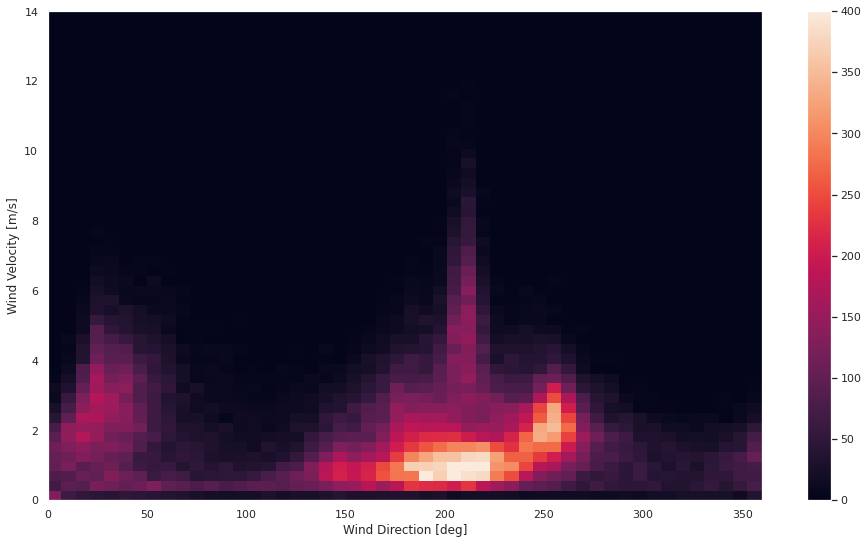

In [ ]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind **vector**:

In [ ]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

The distribution of wind vectors is much simpler for the model to correctly interpret.

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

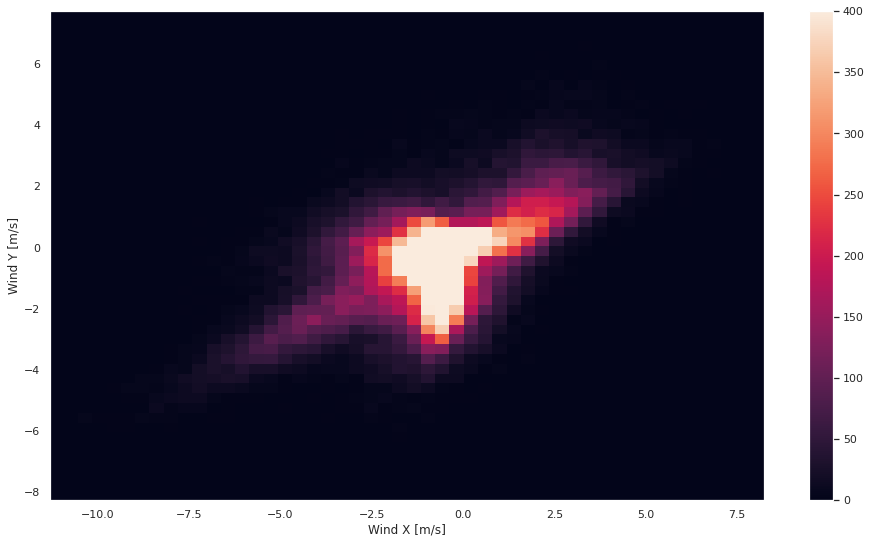

In [ ]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Time

Similarly the `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [ ]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

Similar to the wind direction the time in seconds is not a useful model input. Being weather data it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

A simple approach to convert it to a usable signal is to use `sin` and `cos` to convert the time to clear "Time of day" and "Time of year" signals:

In [ ]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

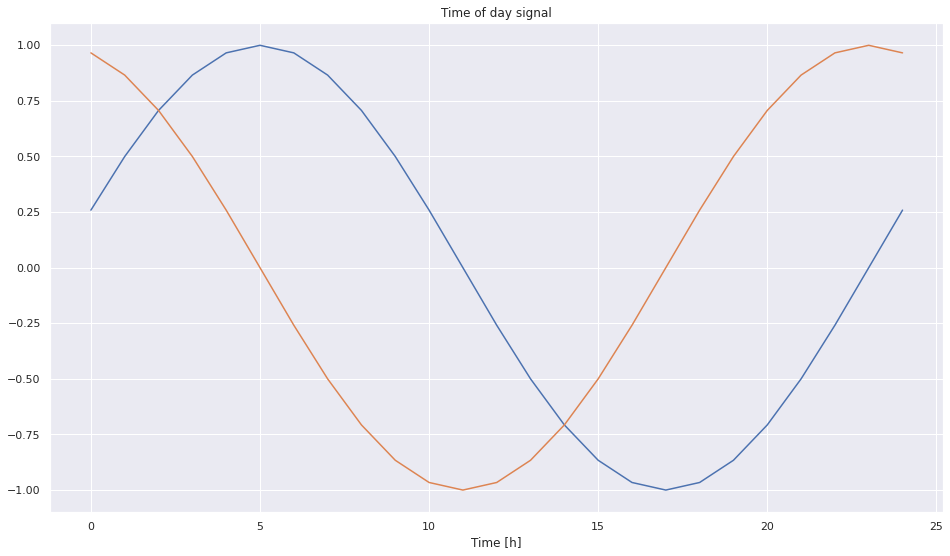

In [ ]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important. 

If you didn't know, you can determine which frequencies are important using an `fft`. To check our assumptions, here is the `tf.signal.rfft` of the temperature over time. Note the obvious peaks at frequencies near `1/year` and `1/day`: 

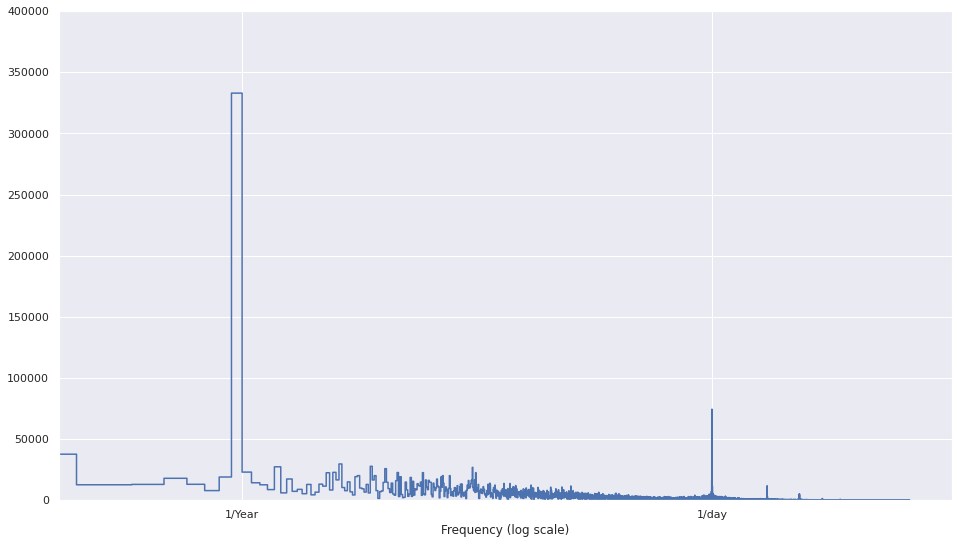

In [ ]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

Correlation between added sine and cosine waves and temperature can be seen. It would probably be more obvious, if the peaks and valleys of added waves matched temperature cycles. 

In [ ]:
df[["T (degC)", "Day sin", "Day cos", "Year sin", "Year cos"]].corr().apply(round, args=(2, ))

,T (degC),Day sin,Day cos,Year sin,Year cos
T (degC),1.00,-0.21,-0.16,-0.23,-0.76
Day sin,-0.21,1.00,0.00,-0.00,-0.00
Day cos,-0.16,0.00,1.00,-0.00,-0.00
Year sin,-0.23,-0.00,-0.00,1.00,0.00
Year cos,-0.76,-0.00,-0.00,0.00,1.00


This is standard way to represent cyclical features in machine learning for continous variables. For more details go to this [blog](http://blog.davidkaleko.com/feature-engineering-cyclical-features.html).

### Split the data

We'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons.

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So in the interest of simplicity this tutorial uses a simple average.

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

### Inverse Transform

Function transforming back to orignal range to compare temperateres in human readable and intuitive units

In [ ]:
def inverse_transform(data, column="T (degC)"):
    return (train_std[column] * data) + train_mean[column]

Now peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

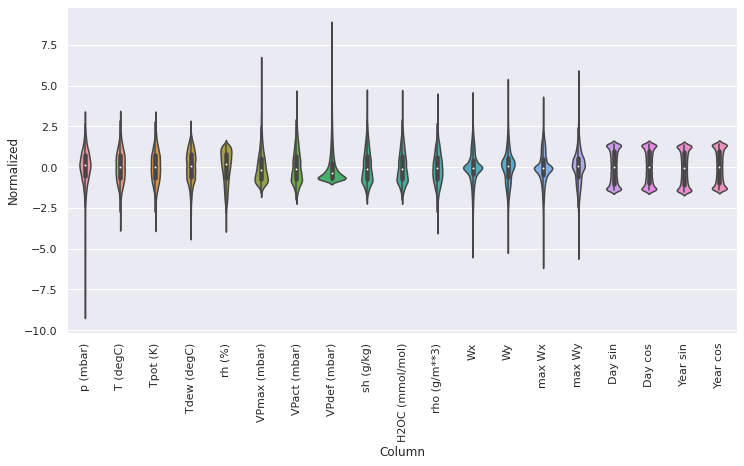

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Windowing

Data is windowed another way than in time series predictions, VAE is only given features and no labels. Representation of all features is required, so they only neccessary Windowing is converting time series to slices and than splitting it into train and test data. 

Class is adjusted `WindowGenerator` from time series tutorial.

In [ ]:
class WindowGenerator:
    def __init__(self, width, train_df=train_df, test_df=test_df, val_df=val_df):
        self.width = width
        self.train_df = train_df
        self.test_df = test_df
        self.val_df = val_df
        self.column_index_mapping = {column: index for index, column in enumerate(train_df.columns.tolist())}
    
    def split(self, df):
        splits = int(len(df.values) / self.width)
        return df.values[:splits * self.width].reshape(splits, self.width, df.values.shape[-1])

    def make_dataset(self, x):
        return tf.data.Dataset.from_tensor_slices(self.split(x))

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def dataset(self):
        return {"train": self.train, "test": self.test, "val": self.val}

    def plot(self, ds="train", model=None, column="T (degC)", transform=False, n_plots=3):
        plt.figure(figsize=(12, 8))
        
        for index, sample_window in zip(range(n_plots), self.dataset[ds].take(n_plots)):
            plt.subplot(n_plots, 1, index + 1)
            plot_feature = sample_window[:, self.column_index_mapping[column]].numpy()
            
            if transform:
                plot_feature = inverse_transform(plot_feature, column=column)

            plt.scatter(1 + np.arange(len(plot_feature)), plot_feature,
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            
            if model is not None:
                predictions = model.reconstruct(tf.expand_dims(sample_window, axis=0))
                prediction = predictions[0, :, self.column_index_mapping[column]].numpy().squeeze()

                if transform:
                    prediction = inverse_transform(prediction, column=column)

                plt.scatter(1 + np.arange(len(prediction)), prediction,
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

Show example plot for 24 hour window

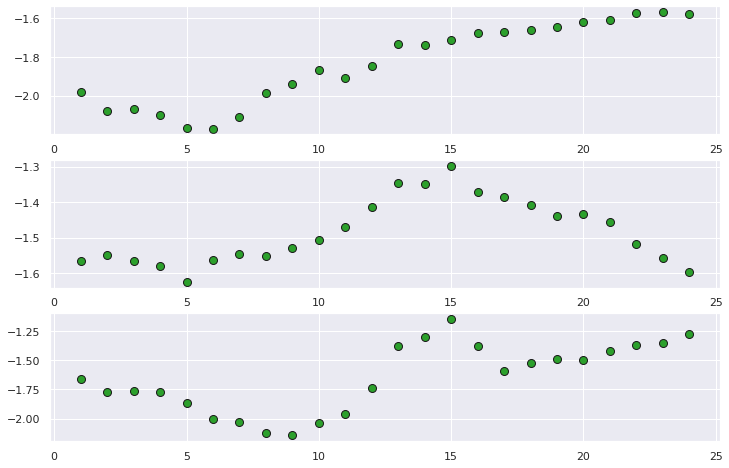

In [ ]:
window = WindowGenerator(width=24)
window.plot()

## Toy Dataset

Generate Toy Dataset with simple sine and cosine waves to illustrate how model works.

In [ ]:
t = np.linspace(0, 1024*np.pi, 100_000)
toy_data = np.vstack([np.sin(t), np.cos(t), np.sin(2*t) + np.cos(2*t), -np.cos(0.5*t)]).T
toy_df = pd.DataFrame.from_records(toy_data, columns=["sin", "cos", "sin + cos", "cos(0.5t)"])

Split toy dataset in the same way as weather data.

In [ ]:
n = len(toy_df)
toy_train_df = toy_df[0:int(n*0.7)]
toy_val_df = toy_df[int(n*0.7):int(n*0.9)]
toy_test_df = toy_df[int(n*0.9):]

Samples from toy dataset are just slices of sines and cosine. Column `"sin + cos"` has highest frequency so it is probably easiest to see on 24 sample windows.

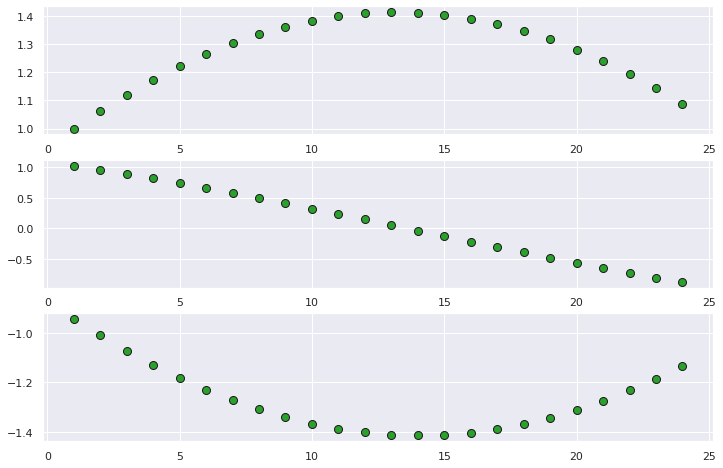

In [ ]:
toy_window = WindowGenerator(width=24, train_df=toy_train_df, test_df=toy_test_df, val_df=toy_val_df)
toy_window.plot(column="sin + cos")

## Utils

Utils for model evaluation.

In [ ]:
def dataset_as_numpy(ds):
    """Convert tensrflow data set to numpy array"""
    return np.asarray([x for x in ds])

List of values for baseline model for typical regression problem. 

* **MSE** - mean squared error
* **MAE** - mean absolute error
* **MAX** - maximal error 
* **R2**  - explained variance coefficient, 0 is predicting the expected value and 1 is perfect score

In [ ]:
def regression_report(y_true, y_pred, precision=2):
    print(f"MSE: {metrics.mean_squared_error(y_true=y_true, y_pred=y_pred):.4f}")
    print(f"MAE: {metrics.mean_absolute_error(y_true=y_true, y_pred=y_pred):.4f}")
    print(f"MAX: {metrics.max_error(y_true=y_true, y_pred=y_pred):.4f}")
    print(f"R2:  {metrics.r2_score(y_true=y_true, y_pred=y_pred):.4f}")

# Variational Autoencoder 

Recurrent Variational Autoencoder works just like Convolutional VAE, but it replaces the convlution and convolution transpose layers with GRU. Final layers of decoder are two time distributed dense layers. Reparametrization and sampling work the same way as previously. 

In [ ]:
class RVAE(tf.keras.Model):
    def __init__(self, latent_dim, n_features, n_time_steps):
        super(RVAE, self).__init__()

        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=[n_time_steps, n_features]),
            tf.keras.layers.GRU(units=32, return_sequences=True),
            tf.keras.layers.GRU(units=64, return_sequences=False),
            tf.keras.layers.Dense(2*latent_dim, activation="linear")
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.RepeatVector(n_time_steps),
            tf.keras.layers.GRU(units=32, return_sequences=True),
            tf.keras.layers.GRU(units=64, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64, activation="relu")),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features, activation="linear")),
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            return tf.sigmoid(logits)
    
        return logits

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=False)

    def reconstruct(self, x):
        mean, logvar = model.encode(x)
        z = model.reparameterize(mean, logvar)
        
        return model.decode(z)


Create model and look at the shapes of inputs and outputs of each layer.

In [ ]:
model = RVAE(latent_dim=2, n_features=4, n_time_steps=24)

In [ ]:
model.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 24, 32)            3648      
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                18816     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 22,724
Trainable params: 22,724
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
repeat_vector_1 (RepeatVecto (None, 24, 2)             0         
_________________________________________________________________
gru_6 (GRU)                  (None, 24, 32)            3456      
_________________________________________________________________
gru_7 (GRU)                  (None, 24, 64)            18816     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 24, 64)            4160      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 24, 4)             260       
Total params: 26,692
Trainable params: 26,692
Non-trainable params: 0
_________________________________________________________________


### Loss Function

Re-use `log_normal_pdf ` function and try to develop loss function for VAE suitable for continous data. 

In [ ]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    distribution = tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)
    
    return tf.cast(distribution, dtype="float64")

Sample one element from train data set and look at produced output

In [ ]:
x = next(iter(toy_window.train))
x.shape, type(x)

(TensorShape([24, 4]), tensorflow.python.framework.ops.EagerTensor)

In [ ]:
# tf.keras.Sequential can only accpet batches of data, so first dim must be equal to 1!
tf.expand_dims(x, axis=0).shape

TensorShape([1, 24, 4])

Model outputs 4D Gaussian

In [ ]:
mean, logvar = model.encode(tf.expand_dims(x, axis=0))

In [ ]:
mean.numpy(), logvar.numpy()

(array([[ 0.18295841, -0.07720442]], dtype=float32),
 array([[0.22234416, 0.08380789]], dtype=float32))

In [ ]:
z = model.reparameterize(mean, logvar)
z.numpy()

array([[ 0.6366231, -2.6508594]], dtype=float32)

In [ ]:
generated_x = model.decode(z)
generated_x.shape  # produces random reconstructed output

TensorShape([1, 24, 4])

**ELBO** loss should be the difference of likiehood and KL divergence between prior and posterior logarithmic probability distributions. As likelihood simple MSE can be used and KL divergence will be the difference between two logarithmic Gaussians one with zero mean and variance, which will be prior and other using mean and variance generated by the model.

In [ ]:
# note this is not MSE!
class VariationalSquaredError(tf.keras.losses.Loss):
    def __init__(self):
        super(VariationalSquaredError, self).__init__()
        
    def __call__(self, y_true, y_pred):
        # for some reason keras changes output of the model to float64
        y_true = tf.cast(y_true, dtype="float64")
        y_pred = tf.cast(y_pred, dtype="float64")

        return tf.cast(tf.math.square(tf.math.subtract(y_pred, y_true)), dtype="float64")


class VariationalLogCosh(tf.keras.losses.Loss):
    def __init__(self):
        super(VariationalLogCosh, self).__init__()
        self.loss_function = tf.keras.losses.LogCosh()

    def __call__(self, y_true, y_pred):
        y_true = tf.cast(y_true, dtype="float64")
        y_pred = tf.cast(y_pred, dtype="float64")

        return tf.cast(tf.math.log(tf.math.cosh(tf.math.subtract(y_pred, y_true))), dtype="float64")


`VariationalLogCosh` is much smoother and penalized abnormal samples less than typical `MSE`. It is still differentiable infinitely many times (smooth) which makes it usable in Machine Learning. 

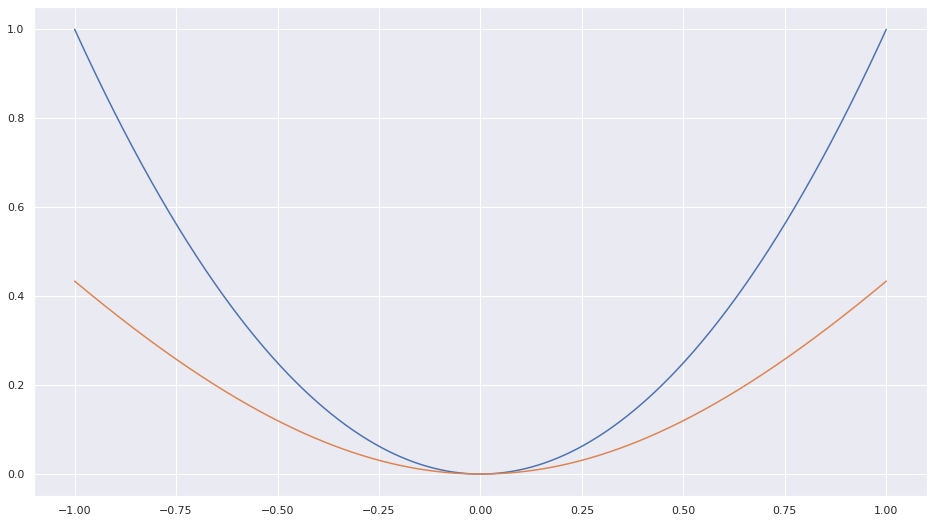

In [ ]:
x = np.linspace(-1, 1, 1000)

vse = VariationalSquaredError()
log_cosh = VariationalLogCosh()

_ = plt.plot(x, vse(x, 0.0))
_ = plt.plot(x, log_cosh(x, 0.0))
_ = plt.legend(["MSE", "LogCosh"])

In [ ]:
# They may have differnt dtypes
# that's why loss classes use casting everywhere
x.dtype, generated_x.dtype

(tf.float64, tf.float32)

In [ ]:
loss = VariationalSquaredError()
loss_values = loss(x, generated_x)
# the same shape as batch size
loss_values.numpy().shape

(1, 24, 4)

In [ ]:
# this has flat 4-th dimension
likelihood = -tf.reduce_sum(loss_values, axis=[1, 2])
likelihood.numpy()

array([-137.29818082])

Use `NegativeMeanSquaredError` on a batch of data.

In [ ]:
x = np.asarray([x for x in toy_window.train.take(10)])
x.shape

(10, 24, 4)

In [ ]:
means, logvars = model.encode(x)
z = model.reparameterize(means, logvars)
generated_x = model.decode(z)

In logarithmic normal distribution 0 variance is equivalent to unit variance in typical normal distribution, because $ log(0) = 1 $ for all possible logarithm bases.

In [ ]:
log_prior = log_normal_pdf(z, 0., 0.)
log_posterior = log_normal_pdf(z, mean, logvar)

Comparing prior and posterior is based on samples from the distribution, this is called Monte Carlo sampling in statistics. It can be used since training data sets are large, so the randomness gets averaged out. This can be motivated using Central Limit Theorem.

In [ ]:
log_prior.numpy(), log_posterior.numpy()

(array([-2.73059988, -9.04487038, -2.93453789, -3.66261601, -2.37196398,
        -2.51928687, -2.19475269, -2.08819103, -3.70629978, -2.00095129]),
 array([-2.77468395, -8.4634819 , -2.65754676, -3.33636618, -2.29728365,
        -2.4339962 , -2.38595438, -2.14477968, -3.90854168, -2.05133486]))

Wrap it all up in single function.

In [ ]:
loss = VariationalSquaredError()

def compute_loss(model, x):
    # encoder mean and logtithm variance vector
    mean, logvar = model.encode(x)
    # reparametrize distribution
    z = model.reparameterize(mean, logvar)
    # decode generated sample
    generated_x = model.decode(z)
    # compute cross entropy between real distribution and decoded image
    loss_values = loss(x, generated_x)
    # likelihood
    likelihood = -tf.reduce_sum(loss_values, axis=[1, 2])
    # prior and posterior distributions
    log_prior = log_normal_pdf(z, 0., 0.)
    log_posterior = log_normal_pdf(z, mean, logvar)
    # filp since, since tensorflow minimizes by default
    return -tf.reduce_mean(likelihood + log_prior - log_posterior)

### Training
Define train step and compile it with `@tf.function` decorator.

In [ ]:
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Learning rate is very important! Too big and model will jump the minima, too small and it will not converage. Probably learning rate scheduling is the way to go.

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)

Wrap everything into one fit function. 

In [ ]:
def fit(model, train_ds, val_ds, n_epochs=10, batch_size=32, print_at=1):
    history = []

    for epoch in range(1, n_epochs + 1):
        start_time = timer()
        for x in train_ds.batch(batch_size):
            train_step(model, x, optimizer)
        end_time = timer()
        # validate
        mean = tf.keras.metrics.Mean()
        for x in val_ds.batch(batch_size):
            mean(compute_loss(model, x))
        
        if epoch % print_at == 0:
            print(f"Time elapsed: {end_time - start_time:.2f} ELBO: {-mean.result():.4f}")
        
        history.append(mean.result())

    return history

In [ ]:
fit(model, toy_window.train, toy_window.val, n_epochs=50)

Time elapsed: 6.25 ELBO: -55.3407
Time elapsed: 0.60 ELBO: -43.0872
Time elapsed: 0.61 ELBO: -36.4616
Time elapsed: 0.61 ELBO: -33.2860
Time elapsed: 0.63 ELBO: -29.7419
Time elapsed: 0.71 ELBO: -28.3752
Time elapsed: 0.56 ELBO: -24.6629
Time elapsed: 0.57 ELBO: -22.8703
Time elapsed: 0.58 ELBO: -21.4965
Time elapsed: 0.56 ELBO: -20.1783
Time elapsed: 0.56 ELBO: -19.0339
Time elapsed: 0.61 ELBO: -18.3053
Time elapsed: 0.69 ELBO: -17.4787
Time elapsed: 0.58 ELBO: -16.7083
Time elapsed: 0.59 ELBO: -16.0326
Time elapsed: 0.66 ELBO: -15.6288
Time elapsed: 0.56 ELBO: -14.8396
Time elapsed: 0.56 ELBO: -14.4311
Time elapsed: 0.56 ELBO: -13.8873
Time elapsed: 0.56 ELBO: -14.1978
Time elapsed: 0.70 ELBO: -13.2428
Time elapsed: 0.70 ELBO: -12.7569
Time elapsed: 0.59 ELBO: -12.8281
Time elapsed: 0.59 ELBO: -11.8920
Time elapsed: 0.60 ELBO: -12.5261
Time elapsed: 0.58 ELBO: -11.6377
Time elapsed: 0.56 ELBO: -11.3372
Time elapsed: 0.57 ELBO: -11.4976
Time elapsed: 0.57 ELBO: -10.8794
Time elapsed: 

### Evaluation

Check how model works on toy data. 

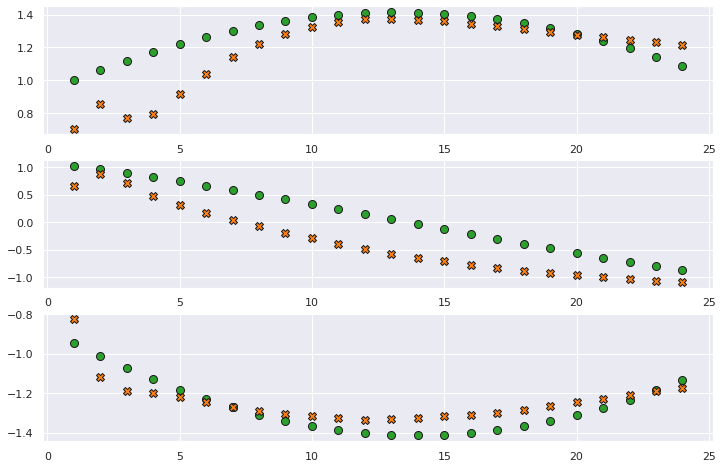

In [ ]:
toy_window.plot(ds="train", model=model, transform=False, column="sin + cos")

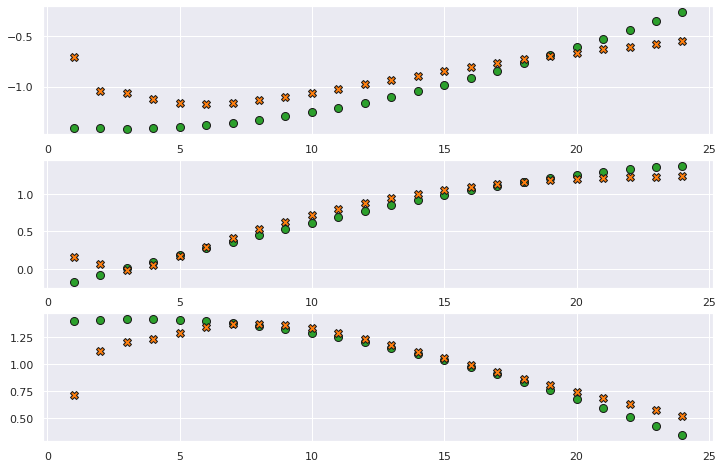

In [ ]:
toy_window.plot(ds="test", model=model, transform=False, column="sin + cos")

### Anomaly detection

How can this be used for anomaly detection?

VAE creates 2D latent space which is regularized, so atypical data points should be visible by investigation this space. 

In [ ]:
def split(df, width=24):
    splits = int(len(df.values) / width)
    return df.values[:splits * width].reshape(splits, width, df.values.shape[-1])

Create and plot the distribution of test samples in generated 2D latent space.  

In [ ]:
means, logvars = model.encode(split(toy_test_df))
latent_representation = model.reparameterize(means, logvars)
latent_representation.shape

TensorShape([416, 2])

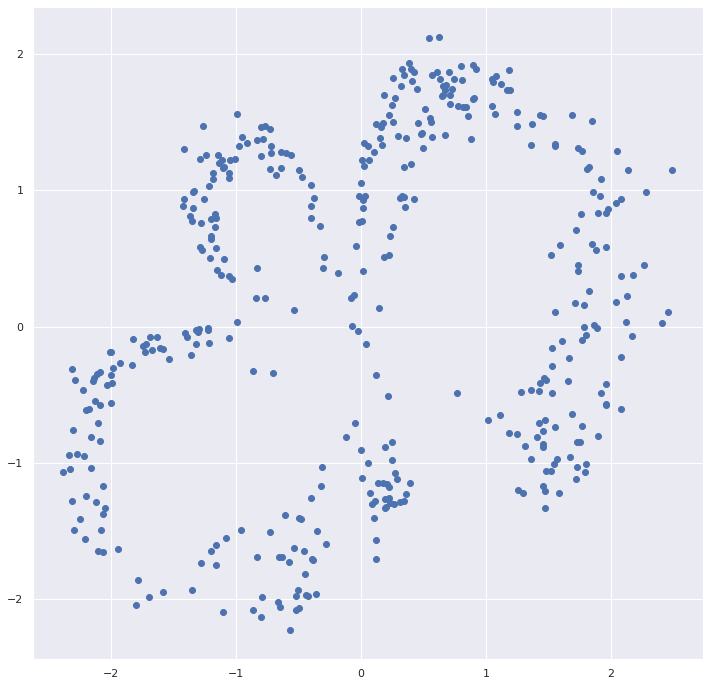

In [ ]:
plt.figure(figsize=[12, 12])
_ = plt.scatter(latent_representation.numpy()[:, 0], latent_representation.numpy()[:, 1])

Create fake dataset, which will serve as anomalies. They should be visible in the latent space as clear outliers.

In [ ]:
t = np.linspace(0, 16*np.pi, 1000)
toy_data = np.vstack([np.sin(t), 0.5 + np.cos(t), np.sin(2*t) + np.cos(2*t), -np.cos(0.5*t)]).T
fake_toy_df = pd.DataFrame.from_records(toy_data, columns=["sin", "cos", "sin + cos", "cos(0.5t)"])

In [ ]:
means, logvars = model.encode(split(fake_toy_df))
detections = model.reparameterize(means, logvars)

TensorShape([41, 2])

Plot of fake, added anomaly. It is just cosine wave shifted up.

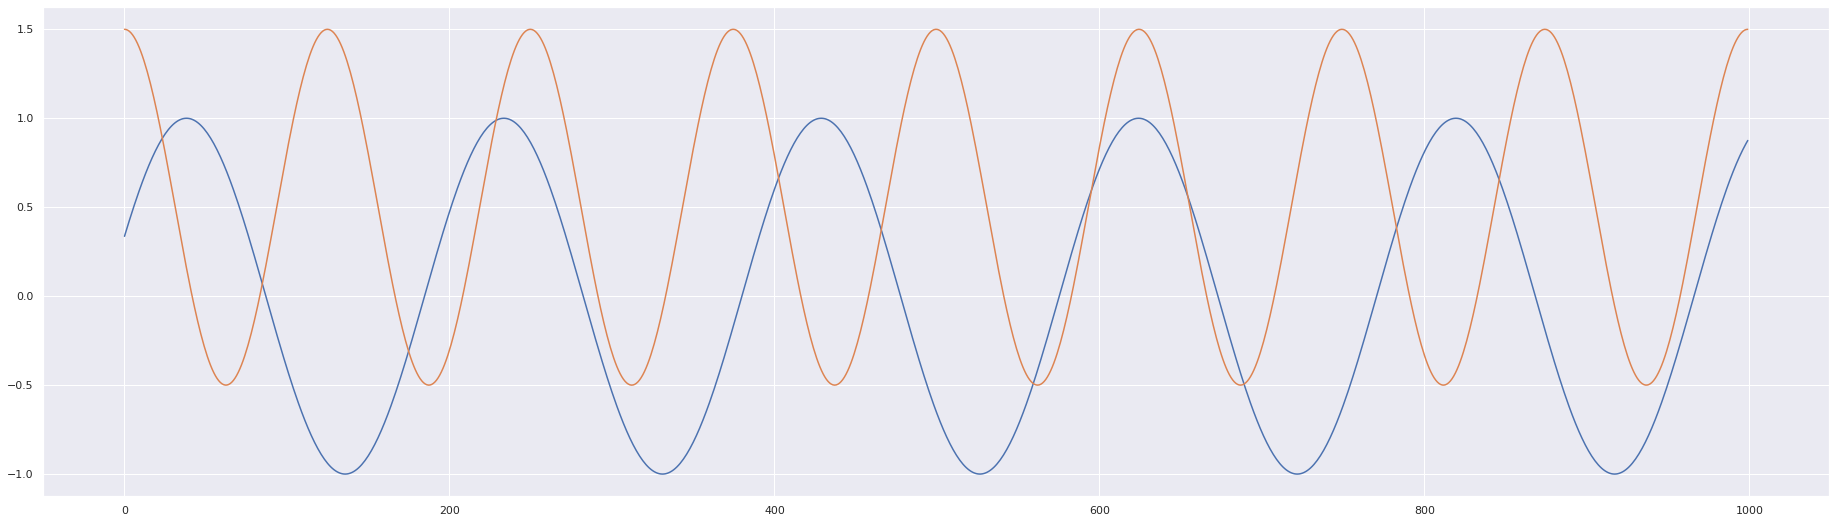

In [ ]:
_ = plt.figure(figsize=[32, 9])
_ = plt.plot(toy_test_df["cos"].values[:1000])
_ = plt.plot(fake_toy_df["cos"].values[:1000])

Red dots markging anomalies are probably quite visible. This is not very clear, but most of them lies outside of the distribution.

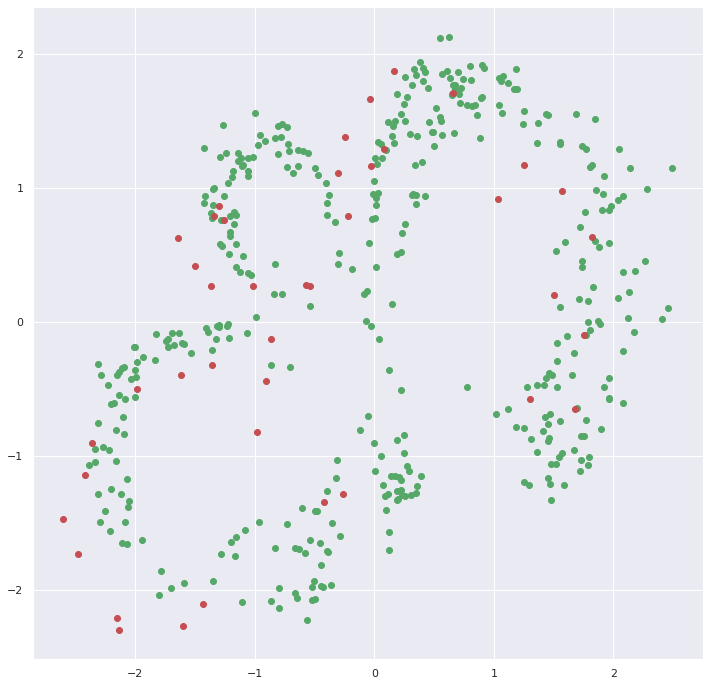

In [ ]:
plt.figure(figsize=[12, 12])
_ = plt.scatter(latent_representation.numpy()[:, 0], latent_representation.numpy()[:, 1], c="g")
_ = plt.scatter(detections.numpy()[:, 0], detections.numpy()[:, 1], c="r")

# Weather Data

Run model on weather data from Max Planck Institute. 

In [ ]:
model = RVAE(latent_dim=8, n_features=19, n_time_steps=24)

Re-compile `train_step` since `@tf.function` can only allocate variables once. 

In [ ]:
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

### Training
Add weights to likelihood and smoothness of prior distribution, to control how model learns better. 

In [ ]:
loss = VariationalLogCosh()

def compute_loss(model, x, likelihood_w=1, regularization_w=1):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    generated_x = model.decode(z)
    loss_values = loss(x, generated_x)
    likelihood = -tf.reduce_sum(loss_values, axis=[1, 2])
    log_prior = log_normal_pdf(z, 0., 0.)
    log_posterior = log_normal_pdf(z, mean, logvar)
    
    return -tf.reduce_mean(likelihood_w * likelihood + regularization_w * (log_prior - log_posterior))


def fit(model, train_ds, val_ds, n_epochs=10, batch_size=32, print_at=1, likelihood_w=1, regularization_w=1):
    history = []

    for epoch in range(1, n_epochs + 1):
        start_time = timer()
        for x in train_ds.batch(batch_size):
            train_step(model, x, optimizer)
        end_time = timer()
        # validate
        mean = tf.keras.metrics.Mean()
        for x in val_ds.batch(batch_size):
            mean(compute_loss(model, x, likelihood_w, regularization_w))
        
        if epoch % print_at == 0:
            print(f"Time elapsed: {end_time - start_time:.2f} ELBO: {-mean.result():.4f}")
        
        history.append(mean.result())

    return history

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-3)
history = fit(model, window.train, window.val, n_epochs=200, print_at=201, likelihood_w=2)  # 201 for silent fit

### Evaluation

Loss function is quite osciliatingm but the model seems to find plateu. 

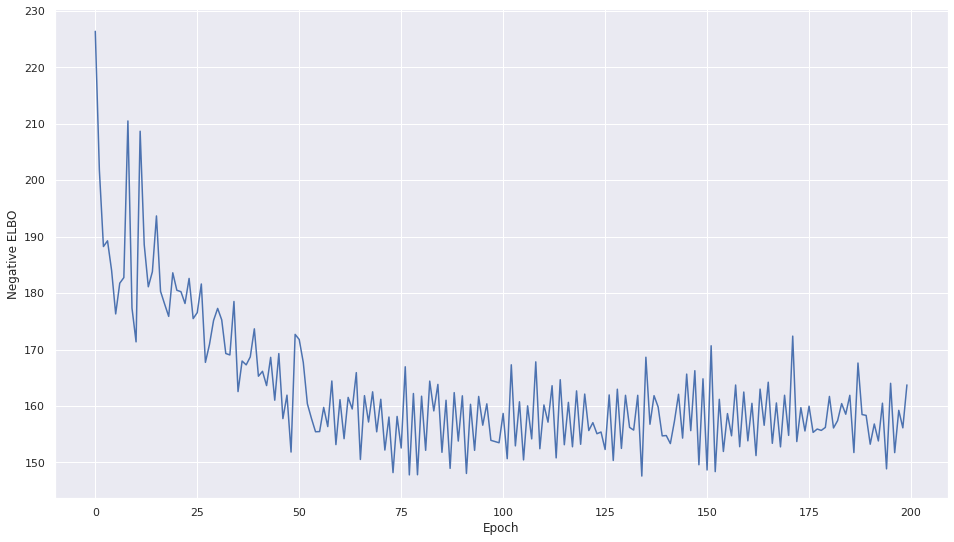

In [ ]:
_ = plt.plot(np.arange(len(history)), history)
_ = plt.xlabel("Epoch")
_ = plt.ylabel("Negative ELBO")

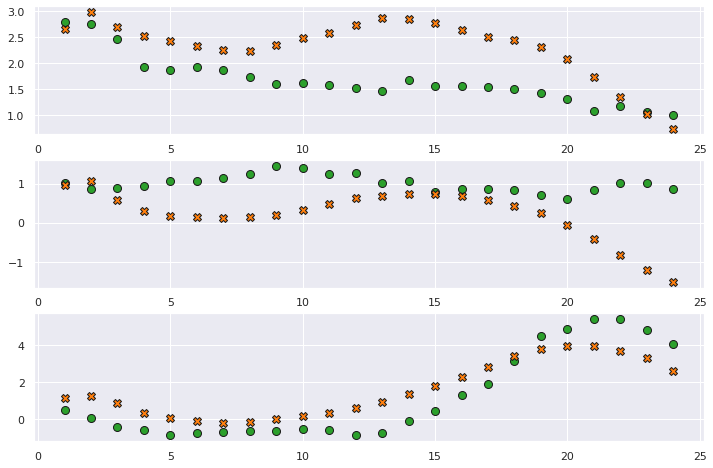

In [ ]:
window.plot(ds="test", model=model, transform=True)

Reconstruction loss is slightly worse than predicting models, but the dimensionality was reduced drastically. Time window with 24 time point and 19 features is exressed as a sum of 8 Gaussians. 

Best prediction models has scores:

| Metric | Value |
|-------|---------|
| MSE | 0.20 |
| MAE | 0.27 |
| MAX | 4.50 |
| $R^2$ | 0.78 |

Results of `RVAE` model are slightly worse, but still very good.

In [ ]:
features = dataset_as_numpy(window.test)
predictions = model.reconstruct(features)

regression_report(y_true=features.flatten(), y_pred=predictions.numpy().flatten())

MSE: 0.2858
MAE: 0.3661
MAX: 4.0125
R2:  0.7077


### Anomaly detection.
Use model to detect weather anomalies. 

Plot real temperature and scaled model outputs. Bar plot is the absolute difference between real data and scaled predictions. The higher the score, the more likely sample is anomalous.

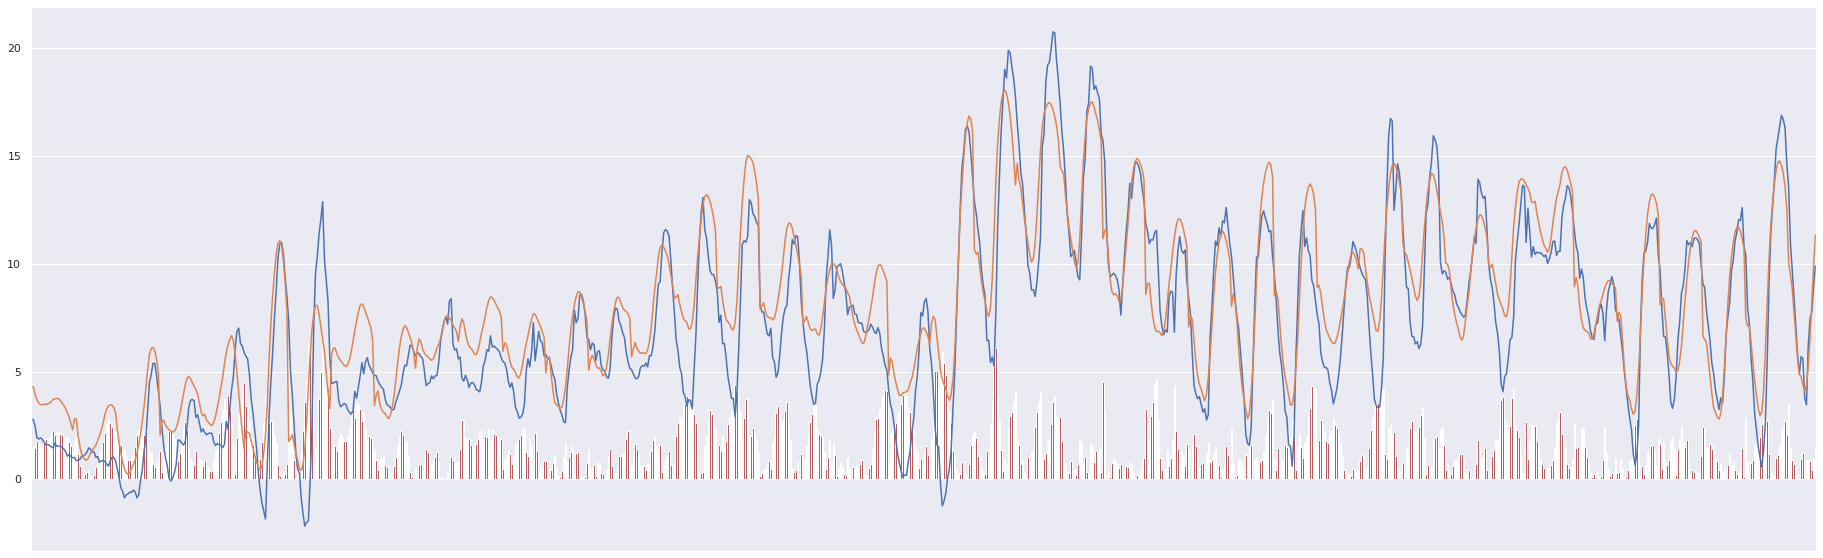

In [ ]:
_ = plt.figure(figsize=[32, 10])

N = 1000
_ = plt.plot(inverse_transform(test_df["T (degC)"].values[:N]))
_ = plt.plot(inverse_transform(predictions.numpy()[:,:,1].flatten()[:N]))

_ = sns.barplot(x=np.arange(N), y=np.abs(inverse_transform(test_df["T (degC)"].values[:N]) - inverse_transform(predictions.numpy()[:,:,1].flatten()[:N])), color="r")
_ = plt.xticks([])

Plot anomaly scores for 500 data points. 

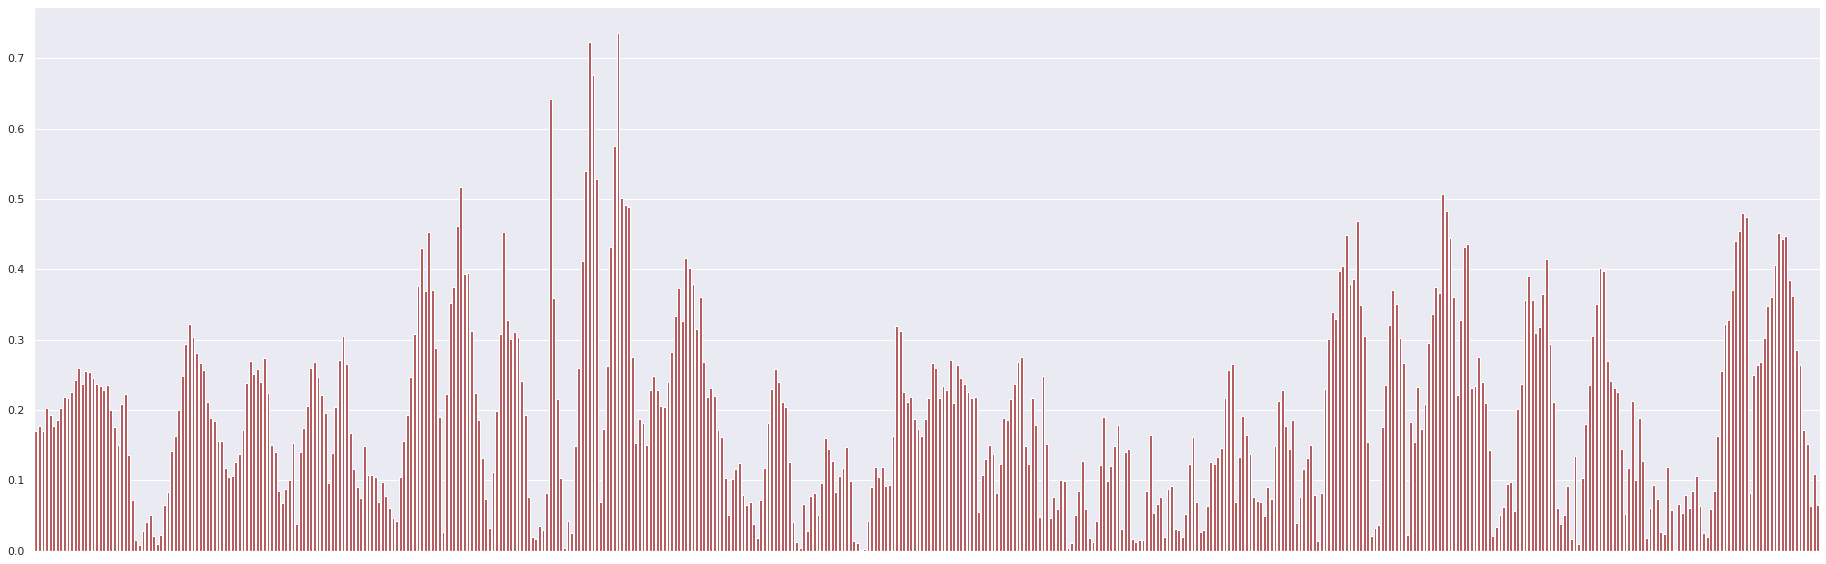

In [ ]:
_ = plt.figure(figsize=[32, 10])

N = 500
_ = sns.barplot(x=np.arange(N), y=np.abs(test_df["T (degC)"].values[:N] - predictions.numpy()[:,:,1].flatten()[:N]), color="r")
_ = plt.xticks([])

Use hard threshold of 1.0 for anomaly detection. Note that this is in just one column to illustrate how VAE could be used for anomaly detection, computing mean score or other kind of aggregation would probably be more efficient, when using all columns.

Threshold of 1.0 results in ~1-2% of detected anomalies.

In [ ]:
N = 7000  # windowing causes dropping 2 samples, but predictions and targets must have the same shape
print(f'{np.sum(np.abs(test_df["T (degC)"].values[:N] - predictions.numpy()[:,:,1].flatten()[:N]) > 1.0) / N:.2%}')

1.41%


In [ ]:
anomalies = np.where(np.abs(test_df["T (degC)"].values[:N] - predictions.numpy()[:,:,1].flatten()[:N]) > 1.0)[0]

Anomalies on the graph are marked with red bars on x axis. It is visible that for those time points the temperature deviates from model reconstruction. In such cases we usually expect temperature to rise, but it falls or the other way around. Those could be considered anomalies, since probably other features suggest rise in temperature, when in truth it drops. 

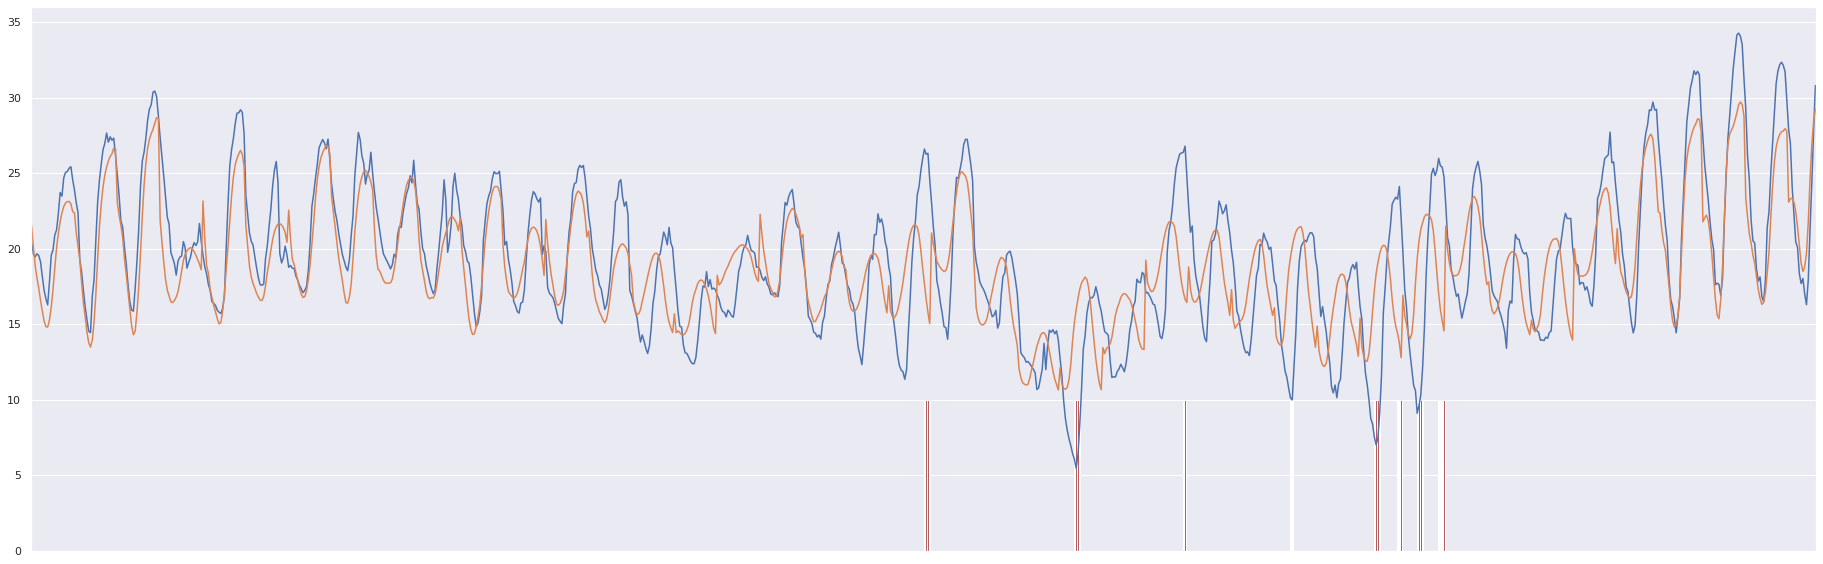

In [ ]:
_ = plt.figure(figsize=[32, 10])

start = anomalies[0] - 500
end = anomalies[0] + 500

_ = plt.plot(inverse_transform(test_df["T (degC)"].values[start:end]))
_ = plt.plot(inverse_transform(predictions.numpy()[:,:,1].flatten()[start:end]))

_ = sns.barplot(x=np.arange(start, end), y=np.vectorize(lambda x: 10*int(x in anomalies))(np.arange(start, end)), color="r")
_ = plt.xticks([])